# Table des Matières
### 1. [Importation des bibliothèques](#importation-des-bibliothèques)
### 2. [Chargement des données et prétraitement](#chargement-des-données)
### 3. [Visualisation des données](#visualisation)
### 4. [Division de l'ensemble de données](#division-des-donnees)
### 5. [Construction du modèle](#creation-du-model)
### 6. [Entraînement du modèle](#entraînement-du-modèle)
### 7. [Affichage des coubres](#affichage-courbes)
### 8. [Evaluation des résultats](#evaluation)
### 9. [Matrice de confusion](#matrice-confusion)
### 10. [Création du ficher de submission](#submission)

<a id='importation-des-bibliothèques'></a>
# Étape 1 : Importation des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from PIL import Image
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id='chargement-des-données'></a>
# Étape 2 : Chargement et prétraitement des données

Nous importons nos images de navires depuis le répertoire ships16x24 et prétraitons ces images pour les préparer pour l'entraînement de notre modèle. Le prétraitement comprend la normalisation des valeurs de pixels entre 0 et 1 et le redimensionnement des images en doublant leurs tailles en utilisant une interpolation bicubique.

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

path = '/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data'

raw_dataset = tf.keras.utils.image_dataset_from_directory(path, labels='inferred', image_size=(16,24))

def preprocess_images(images, labels):
    normalized_images = images / 255.0
    original_shape = tf.shape(normalized_images)[1:3]
    new_shape = original_shape * 2
    resized_image = tf.image.resize(normalized_images, new_shape, method=tf.image.ResizeMethod.BICUBIC)
    
    return resized_image, labels

dataset = raw_dataset.map(preprocess_images)
images, labels = zip(*list(dataset.unbatch().as_numpy_iterator()))

Found 35515 files belonging to 10 classes.


<a id='visualisation'></a>
# Étape 3 : Visualisation des données

Afin de mieux comprendre nos données, nous visualisons un sous-ensemble d'images de navires. Nous créons également un histogramme pour visualiser la distribution des classes dans notre ensemble de données.

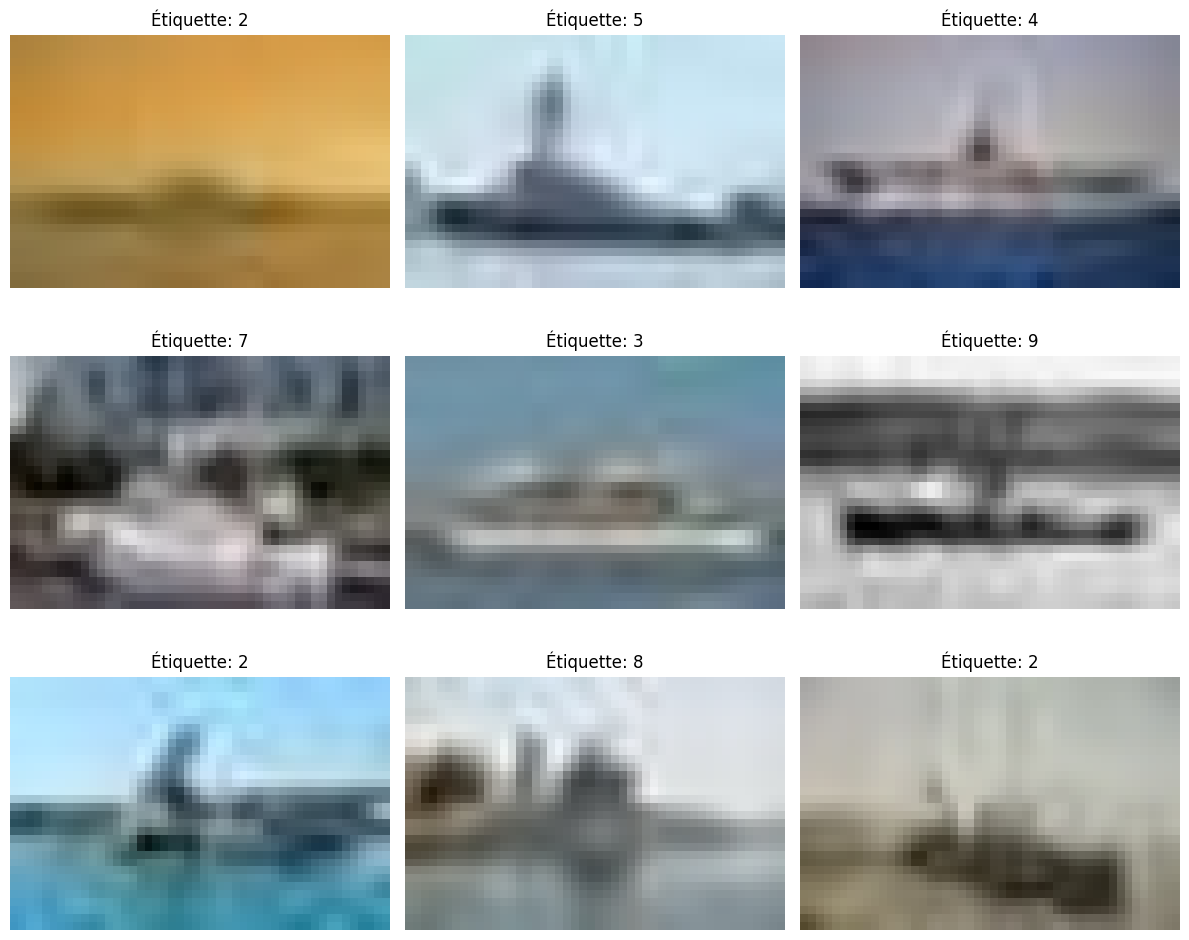

In [3]:
import matplotlib.pyplot as plt

num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Étiquette: {labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Affichage du nombres d'images par classes sous forme d'histogramme

In [4]:
def hist_data(label_list):
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(x=label_list, order=sorted(set(label_list)))
    plt.title('Nombre d\'images par classe')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'images')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=10)
    plt.show()

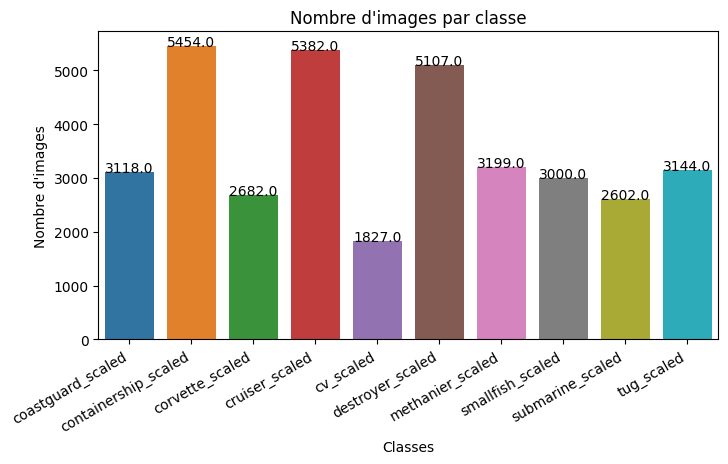

In [5]:
class_names = raw_dataset.class_names
label_list = [class_names[label] for label in labels]

hist_data(label_list)

<a id='division-des-donnees'></a>
# Étape 4 : Division des données

Nous divisons notre ensemble de données en ensembles d'entraînement, de validation, et de test. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Nombre d'image dans les données de train :", len(X_train))
print("Nombre d'image dans les données de validation:", len(X_val))
print("Nombre d'image dans les données de test:", len(X_test))

Nombre d'image dans les données de train : 19977
Nombre d'image dans les données de validation: 6659
Nombre d'image dans les données de test: 8879


<a id='creation-du-model'></a>
# Étape 5 : Création du modèle

J'ai utilisé une variante du model de VGG16 pour choisir mon modèle en le modifiant en fonction les résultats

In [8]:
from tensorflow.keras import layers, models, regularizers

def create_cnn_model1():
    model = models.Sequential()

    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 48, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

cnn_model1 = create_cnn_model1()
cnn_model1.summary()
print("Nombre de couches model 1: ", len(cnn_model1.layers))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 24, 32)       0         
 )                                                               
                                                        

<a id='entrainement-model'></a>
# Étape 6 : Entraînement du modèle

Pour ne pas commencer l'entrainement de zéro sur ce notebook, j'ai déja entrainé le modèle et j'ai téléchargé les poids qui ont produits le meilleur résultat.

La cross validation peremt de réduire le problème d'overfitting du modèle.

Entrainement du modèle en cross validation à l'aide de StratifiedKFold. L'ensemble des données est divisé de telle manière que chaque sous-ensemble a la même proportion de classes que l'ensemble des données original.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight

datagen = ImageDataGenerator(horizontal_flip=True)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

initial_learning_rate = 0.001  # Reduced learning rate

val_accuracy_scores = []

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

cnn_model1.load_weights(f'cnn_model1_fold_{5}.h5')

for i, (train, val) in enumerate(kfold.split(X_train, y_train)):
    print(f"Training on Fold: {i+1}")
    optimizer_adam = Adam(learning_rate=initial_learning_rate)
    cnn_model1.compile(optimizer=optimizer_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)  # Reduced patience
    early_stop = EarlyStopping(monitor='val_loss', patience=5)  # Reduced patience
    
    history = cnn_model1.fit(datagen.flow(X_train[train], y_train[train], batch_size=64),
                            steps_per_epoch=len(X_train[train]) / 64,
                            epochs=10,
                            validation_data=(X_train[val], y_train[val]),
                            class_weight=class_weights,
                            callbacks=[reduce_lr, early_stop])        

    val_loss, val_accuracy = cnn_model1.evaluate(X_train[val], y_train[val], verbose=0)
    print(f"Fold: {i+1}, val_accuracy: {val_accuracy}")
    val_accuracy_scores.append(val_accuracy)

print('\n')
print(f"Average validation accuracy: {np.mean(val_accuracy_scores):.4f}")

Training on Fold: 1
Epoch 1/10


2023-05-29 15:24:34.413151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 11s 21ms/step - loss: 0.3063 - accuracy: 0.8957 - val_loss: 0.1355 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2947 - accuracy: 0.8990 - val_loss: 0.1577 - val_accuracy: 0.9449 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 5s 19ms/step - loss: 0.3204 - accuracy: 0.8892 - val_loss: 0.1758 - val_accuracy: 0.9434 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 5s 20ms/step - loss: 0.2930 - accuracy: 0.8999 - val_loss: 0.1975 - val_accuracy: 0.9344 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 5s 20ms/step - loss: 0.2446 - accuracy: 0.9155 - val_loss: 0.1372 - val_accuracy: 0.9567 - lr: 2.0000e-04
Epoch 6/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2165 - accuracy: 0.9243 - val_loss: 0.1259 - val_accuracy: 0.9577 - lr: 2.0000e-04
Epoch 7/10
249/249 [==============================] - 5s 19ms/step

2023-05-29 15:25:39.862496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 12s 21ms/step - loss: 0.2885 - accuracy: 0.8996 - val_loss: 0.0774 - val_accuracy: 0.9785 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2914 - accuracy: 0.8990 - val_loss: 0.1739 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 5s 21ms/step - loss: 0.2768 - accuracy: 0.9025 - val_loss: 0.1107 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2820 - accuracy: 0.9026 - val_loss: 0.1533 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2259 - accuracy: 0.9211 - val_loss: 0.0722 - val_accuracy: 0.9782 - lr: 2.0000e-04
Epoch 6/10
249/249 [==============================] - 5s 19ms/step - loss: 0.1960 - accuracy: 0.9307 - val_loss: 0.0813 - val_accuracy: 0.9722 - lr: 2.0000e-04
Epoch 7/10
249/249 [==============================] - 5s 19ms/step

2023-05-29 15:26:44.271220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 11s 21ms/step - loss: 0.2668 - accuracy: 0.9081 - val_loss: 0.1050 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2630 - accuracy: 0.9086 - val_loss: 0.0861 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 5s 21ms/step - loss: 0.2598 - accuracy: 0.9101 - val_loss: 0.0937 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 5s 20ms/step - loss: 0.2499 - accuracy: 0.9140 - val_loss: 0.1178 - val_accuracy: 0.9612 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2515 - accuracy: 0.9106 - val_loss: 0.1043 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 6/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2004 - accuracy: 0.9278 - val_loss: 0.0700 - val_accuracy: 0.9795 - lr: 2.0000e-04
Epoch 7/10
249/249 [==============================] - 5s 19ms/step - l

2023-05-29 15:27:57.516819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 12s 23ms/step - loss: 0.2346 - accuracy: 0.9178 - val_loss: 0.2326 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2520 - accuracy: 0.9138 - val_loss: 0.0638 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 5s 20ms/step - loss: 0.2369 - accuracy: 0.9155 - val_loss: 0.0846 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2357 - accuracy: 0.9187 - val_loss: 0.1110 - val_accuracy: 0.9627 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 5s 20ms/step - loss: 0.2200 - accuracy: 0.9226 - val_loss: 0.1111 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 6/10
249/249 [==============================] - 5s 20ms/step - loss: 0.1786 - accuracy: 0.9377 - val_loss: 0.0448 - val_accuracy: 0.9880 - lr: 2.0000e-04
Epoch 7/10
249/249 [==============================] - 5s 21ms/step - l

2023-05-29 15:28:57.519161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 11s 21ms/step - loss: 0.2254 - accuracy: 0.9198 - val_loss: 0.0339 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 6s 22ms/step - loss: 0.2231 - accuracy: 0.9189 - val_loss: 0.1097 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2166 - accuracy: 0.9238 - val_loss: 0.1367 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 5s 19ms/step - loss: 0.2237 - accuracy: 0.9225 - val_loss: 0.2195 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 5s 20ms/step - loss: 0.1790 - accuracy: 0.9379 - val_loss: 0.0301 - val_accuracy: 0.9927 - lr: 2.0000e-04
Epoch 6/10
249/249 [==============================] - 5s 20ms/step - loss: 0.1588 - accuracy: 0.9443 - val_loss: 0.0256 - val_accuracy: 0.9950 - lr: 2.0000e-04
Epoch 7/10
249/249 [==============================] - 5s 21ms/step

<a id='affichage-courbes'></a>
# Etape 7 : Affichage des courbes après l'entrainement

In [15]:
def plot_learning_curves(history, name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(name + "accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name + "loss")

    plt.legend()
    plt.show()

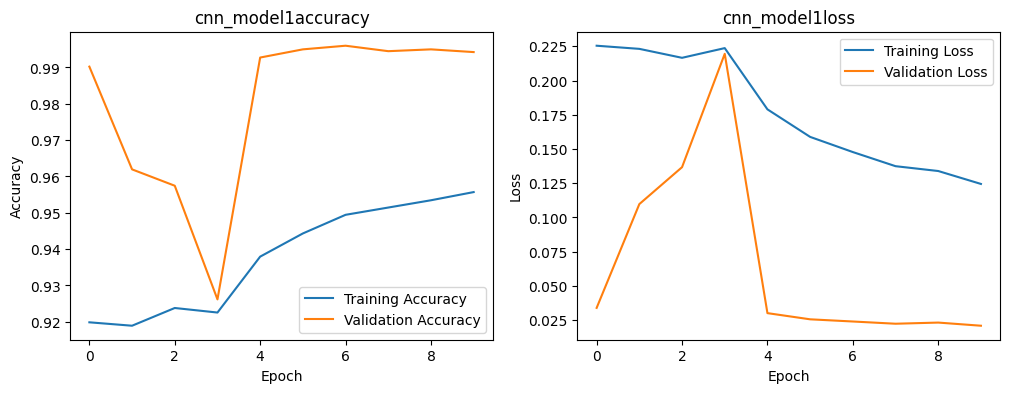

cnn_model1 :
  Précision d'entraînement: 0.9557
  Précision de validation: 0.9942


In [16]:
plot_learning_curves(history.history, 'cnn_model1')
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("cnn_model1 :")
print(f"  Précision d'entraînement: {train_acc[-1]:.4f}")
print(f"  Précision de validation: {val_acc[-1]:.4f}")

<a id='evaluation'></a>
# Etape 8 :Evaluation du model sur les données de test

In [17]:
test_loss, test_acc = cnn_model1.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

278/278 - 1s - loss: 0.9325 - accuracy: 0.7650 - 1s/epoch - 4ms/step

Test accuracy: 0.7649509906768799


<a id='matrice-confusion'></a>
# Création de la matrice de confusion

In [21]:
from sklearn.metrics import confusion_matrix

y_pred = cnn_model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

278/278 [==============================] - 1s 3ms/step


<a id='chargement-des-données'></a>
# Affichage de la matrice de confusion

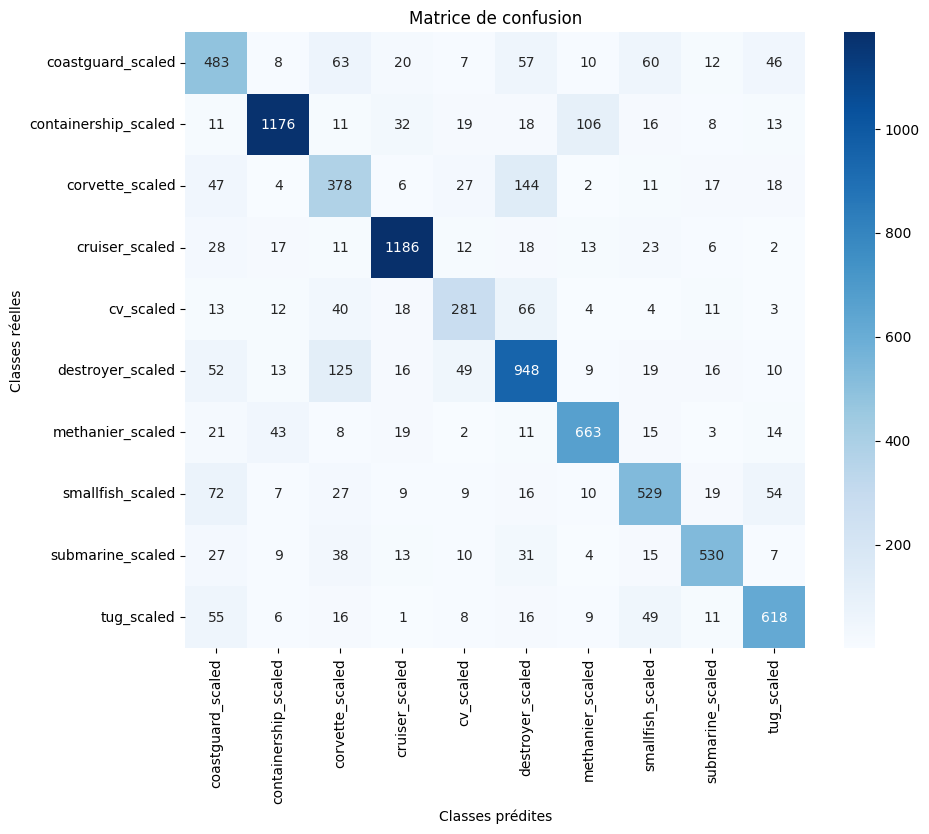

In [19]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice de confusion')
    plt.xlabel('Classes prédites')
    plt.ylabel('Classes réelles')
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)